<a href="https://colab.research.google.com/github/Malikshemi3344/datascienceproject/blob/main/datascience_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Creditcard fraud detection**

In [2]:
#import all necessary libraris
import numpy as np
import pandas as pd
#for creating and plotting the correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import seaborn as sns

In [3]:
#for downloading dataset direct from kaggle
import kagglehub

In [4]:
#libraries for implementing SMOTE{to handle imbalance class}
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [5]:
from os import path
#download dataset and import the csv file uning pandas
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
#print some data to analeyze
print(data.head(1))

100%|██████████| 66.0M/66.0M [00:03<00:00, 21.1MB/s]

Extracting files...


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  

[1 rows x 31 columns]


In [6]:
#print the shape of the data as well as the descrisption for all the fields
print(data.shape)
print(data.describe())

(284807, 31)
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271

In [7]:
#determine the fraud cases and valid transactions
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]
outlierFraction = len(fraud)/float(len(valid))
print(outlierFraction)
print('Fraud Cases:{}'.format(len(data[data['Class']==1])))
print('Valid Transactions:{}'.format(len(data[data['Class']==0])))
corrmat = data.corr()


0.0017304750013189597
Fraud Cases:492
Valid Transactions:284315


In [8]:
#apply thresholding:map correlation values to -1,0 and 1
#1:perfect positive linear correlation
#-1:perfect negative linear correlation
#0:no linear correlation
corr_discrete = corrmat.applymap(lambda x: 1 if x > 0.5 else (-1 if x < -0.5 else 0))

<ipython-input-8-28d14be5675e>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  corr_discrete = corrmat.applymap(lambda x: 1 if x > 0.5 else (-1 if x < -0.5 else 0))


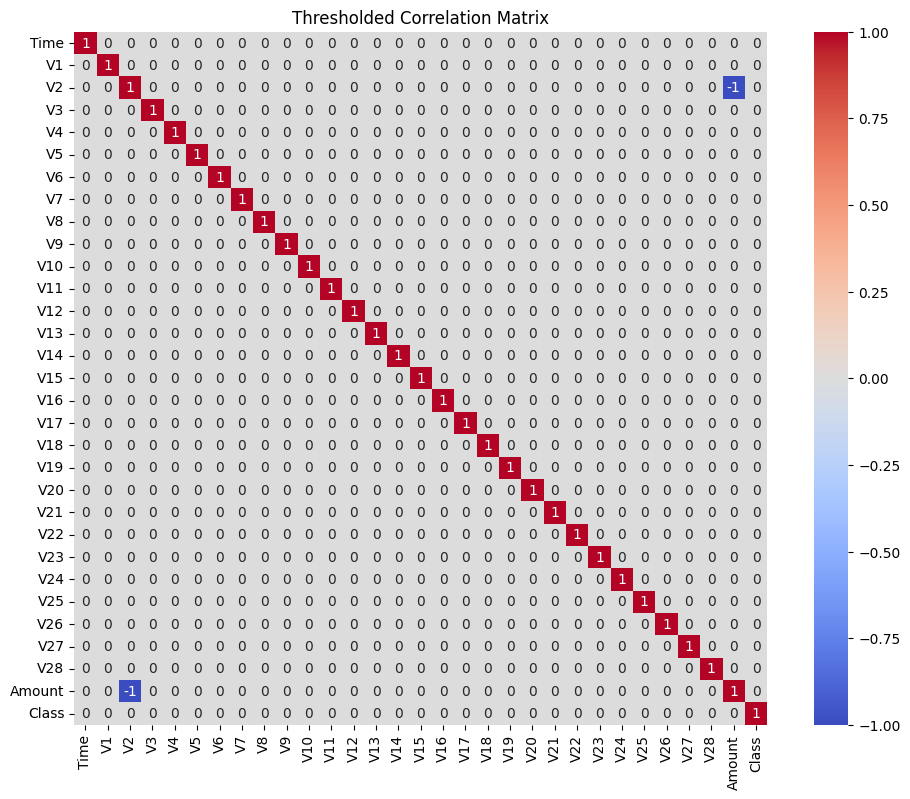

In [9]:
#plotting heatmap for the  correlation matrix
fig = plt.figure(figsize=(12,9))
sns.heatmap(corr_discrete,annot=True,cmap="coolwarm",square=True,cbar=True)
plt.title("Thresholded Correlation Matrix")
plt.show()

In [17]:
#seprate the feature and tragets/labels
X = data.drop(columns=['Class'])
y = data['Class']
#splite the data into traing and test set using sklearn library
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)
#Now in order to handle class imbalance we will apply smote (Synthetic Minority Over-sampling Technique)
#It is a technique that reduces imbalance in datasets by creating synthetic samples of the minority class which in our case is the fradulent transactions
#For now, we are trying to create 1000 more samples for our fraud class
desired_samples_class_1 = 1000
#apply smote
somte = SMOTE(sampling_strategy={1:desired_samples_class_1},random_state=42,)
X_train_smote,y_train_smote = somte.fit_resample(X_train,y_train)
#check the  number of samples in the combined dataset
print("Orignal training samples:",len(X_train))
print("synthetic samples gernated for class 1:",len(X_train_smote)-len(y_train))
#here we notice that SMOTE tried to return as many samples as it can depending upon the class diversity available
print("Total samples in combined trianing dataset:",len(X_train_smote))
  #combined X and y data for the resampling training dataset
resampled_data = pd.concat([X_train_smote,y_train_smote],axis=1)
#save all data in new csv
resampled_data.to_csv("resampled_creditcard_fraud.csv",index=False)
print("synthetic samples saved to'resampled_creditcard_fraud.csv'")

Orignal training samples: 227845
synthetic samples gernated for class 1: 606
Total samples in combined trianing dataset: 228451
synthetic samples saved to'resampled_creditcard_fraud.csv'


In [25]:
#scaling the data
#logistic regration is sensitive to feature scales,so we use StandardScaler to standardize the data
#StandardScaler scales the dta so that each feature has a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
#fit the scaler on the the training data and transform it to make the data standardized
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
#use the same scaler(already fit on the training data)to tranform the test data
#this ensures that the test data is scaled using the same scaling factors as a training data
X_test_scaled = scaler.transform(X_test)
#intializ the logistic regression model
#here we are specifying
#'max_iter=5000':allow the model run to 5000 ilteratioms(model having troble converging with less iterstion than this)
#solver='saga':this is an optimization algorithim,particularly good for large dataset or sparse data(so the model converges wirh ease)
#`random_state=42`: Ensures reproducibility of results
log_reg = LogisticRegression(max_iter=5000,solver='saga',random_state=42)
#fit the model on the training data
#Train the Logistic Regression model
# .fit() method trains the model using the scaled training data (X_train_smote_scaled)
log_reg.fit(X_train_smote_scaled,y_train_smote)
#make predictions on the test data
y_pred = log_reg.predict(X_test_scaled)
# .predict_proba() method gives probabilities for each class (0 or 1).
# We're taking probabilities for the positive class (fraudulent transactions) with [:, 1]
y_pred_prob = log_reg.predict_proba(X_test_scaled)[:,1]

**Evaluating Model Perfromance**


===confusion matrix===
[[56836    28]
 [   23    75]]


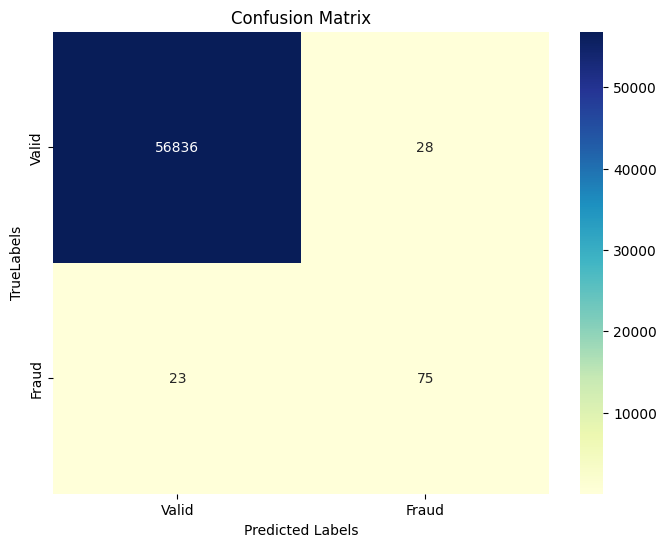


===classification report===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.77      0.75        98

    accuracy                           1.00     56962
   macro avg       0.86      0.88      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy (manual calculation): 0.9991 (99.91%)
Accuracy (sklearn calculation): 0.9991 (99.91%)


In [36]:
# Confusion Matrix
# The confusion matrix helps us evaluate the performance of our model by showing the count of the following
# True Positive (TP): correctly predicted fraud cases, True Negative (TN): correctly predicted valid transactions
# False Positive (FP): incorrectly predicted fraud cases (valid transactions predicted as fraud), False Negative (FN): incorrectly predicted valid transactions (fraud cases predicted as valid)
conf_matrix = confusion_matrix(y_test,y_pred)
#print the confusion matrix
print("\n===confusion matrix===")
print(conf_matrix)
#visualizing the confusion martic
#using heatmap for better visual representation
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap="YlGnBu",xticklabels=['Valid','Fraud'],yticklabels=['Valid','Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("TrueLabels")
plt.show()
# The classification report provides a detailed evaluation of the model
# Precision: The percentage of correctly predicted fraud cases
# Recall: The percentage of correctly predicted fraud instances among all actual fraud cases
# F1-score: The harmonic mean of precision and recall
#  Support: The number of actual instances of each class in the dataset
class_report = classification_report(y_test,y_pred)
print("\n===classification report===")
print(class_report)
#calculate accuracy
#(True positives+True negatives)/total samples
accuracy = (conf_matrix[0][0] + conf_matrix[1][1]) / conf_matrix.sum()
#we aslo use accuracy_score function from scikilearn to calculate acuracy
accuracy_sklearn = accuracy_score(y_test,y_pred)
#print the accuracy
print(f"Accuracy (manual calculation): {accuracy:.4f} ({accuracy * 100:.2f}%)")
print(f"Accuracy (sklearn calculation): {accuracy_sklearn:.4f} ({accuracy_sklearn * 100:.2f}%)")
